
# Pneumonia Detection using EfficientNetB0
# Author: Sriraj Thiruchety
# Description: Deep learning model using transfer learning to classify chest X-rays as either Normal or Pneumonia.


 Authenticate and configure the Kaggle API to download datasets. Fetch the 'chest-xray-pneumonia' dataset and extract it into a local directory for further processing.


In [1]:
# ✅ STEP 1: Install and Setup Kaggle API
!pip install -q kaggle

import os
import zipfile
from google.colab import files

# Upload your kaggle.json file
print("Upload kaggle.json file from your Kaggle account")
files.upload()

# Set up the Kaggle API credentials
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


Upload kaggle.json file from your Kaggle account


Saving kaggle.json to kaggle.json


Load image files from extracted directories, resize them uniformly to match input shape requirements, assign labels based on folder names, and prepare a structured DataFrame for further use.


In [2]:
# ✅ STEP 2: Download and Unzip Chest X-Ray Pneumonia Dataset from Kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

with zipfile.ZipFile("chest-xray-pneumonia.zip", 'r') as zip_ref:
    zip_ref.extractall("chest_xray")

# Verify folder contents
print("Extracted folders:", os.listdir("chest_xray"))


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
Extracted folders: ['chest_xray']


Split the preprocessed dataset into training and validation subsets using stratification to preserve the proportion of classes in each set.


In [3]:
# ✅ STEP 3: Import Required Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Create training and validation data generators with real-time augmentation (e.g., rotations, zoom, flips) for improved generalization and to reduce overfitting.


In [4]:
# ✅ STEP 4: Define Paths and Set Image Parameters
train_dir = "chest_xray/chest_xray/train"
val_dir = "chest_xray/chest_xray/val"
test_dir = "chest_xray/chest_xray/test"

image_size = (224, 224)
batch_size = 4


Construct a modular custom CNN architecture comprising convolutional blocks, batch normalization, pooling, and dropout layers for robust feature learning and classification.


In [5]:
# ✅ STEP 5: Data Augmentation and Preprocessing

# For training: apply augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True
)

# For validation and testing: only rescale
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from directories
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Compile the CNN model using the Adam optimizer and categorical cross-entropy as the loss function. Include accuracy as a metric to monitor performance.


In [6]:
# ✅ STEP 6: Define Custom CNN Model Architecture
def create_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    # Block 2
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    # Block 3
    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    # Classifier
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = create_cnn()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,785,026 (98.36 MB)

 Trainable params: 25,784,578 (98.36 MB)

 Non-trainable params: 448 (1.75 KB)

Calculate class weights based on training data distribution and incorporate them into the training process to handle class imbalance.


In [7]:
# ✅ STEP 7: Define Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)

callbacks = [checkpoint, early_stop, reduce_lr]


Train the CNN using the augmented training data. Apply callbacks like ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau. Ensure all epochs execute for maximum accuracy.


In [10]:
# ✅ STEP 8: Train the Model for all Epochs (no early stopping), aggressive LR reduction

epochs = 30  # Increase epochs for more learning capacity

# Only use ModelCheckpoint and ReduceLROnPlateau (no early stopping)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-7, verbose=1)

callbacks = [checkpoint, reduce_lr]

# Start training
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // batch_size,
    validation_data=val_gen,
    validation_steps=val_gen.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8629 - loss: 0.5929
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.h5


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 109s 84ms/step - accuracy: 0.8629 - loss: 0.5928 - val_accuracy: 0.6250 - val_loss: 1.5099 - learning_rate: 3.0000e-04
Epoch 2/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9103 - loss: 0.2586
Epoch 2: val_accuracy did not improve from 0.62500
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 136s 79ms/step - accuracy: 0.9103 - loss: 0.2586 - val_accuracy: 0.6250 - val_loss: 0.6467 - learning_rate: 3.0000e-04
Epoch 3/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9125 - loss: 0.2137
Epoch 3: val_accuracy did not improve from 0.62500
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 140s 78ms/step - accuracy: 0.9125 - loss: 0.2137 - val_accuracy: 0.5000 - val_loss: 1.4311 - learning_rate: 3.0000e-04
Epoch 4/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9292 - loss: 0.1854
Epoch 4: val_accuracy improved from 0.62500 to 0.81250, saving model to best_model.h5


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 104s 80ms/step - accuracy: 0.9292 - loss: 0.1854 - val_accuracy: 0.8125 - val_loss: 0.3794 - learning_rate: 3.0000e-04
Epoch 5/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9350 - loss: 0.1706
Epoch 5: val_accuracy did not improve from 0.81250
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 140s 79ms/step - accuracy: 0.9350 - loss: 0.1706 - val_accuracy: 0.6250 - val_loss: 0.8567 - learning_rate: 3.0000e-04
Epoch 6/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9335 - loss: 0.1648
Epoch 6: val_accuracy improved from 0.81250 to 0.87500, saving model to best_model.h5


1304/1304 ━━━━━━━━━━━━━━━━━━━━ 103s 79ms/step - accuracy: 0.9335 - loss: 0.1648 - val_accuracy: 0.8750 - val_loss: 0.3369 - learning_rate: 3.0000e-04
Epoch 7/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9431 - loss: 0.1571
Epoch 7: val_accuracy did not improve from 0.87500
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 141s 78ms/step - accuracy: 0.9431 - loss: 0.1571 - val_accuracy: 0.8125 - val_loss: 0.3716 - learning_rate: 3.0000e-04
Epoch 8/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9274 - loss: 0.2041
Epoch 8: val_accuracy did not improve from 0.87500

Epoch 8: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.9274 - loss: 0.2041 - val_accuracy: 0.7500 - val_loss: 0.8550 - learning_rate: 3.0000e-04
Epoch 9/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9604 - loss: 0.1337
Epoch 9: val_accuracy did not improve from 0.87500
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accur

1304/1304 ━━━━━━━━━━━━━━━━━━━━ 105s 81ms/step - accuracy: 0.9589 - loss: 0.1241 - val_accuracy: 0.9375 - val_loss: 0.2586 - learning_rate: 6.0000e-05
Epoch 11/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9600 - loss: 0.1131
Epoch 11: val_accuracy did not improve from 0.93750
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 139s 78ms/step - accuracy: 0.9600 - loss: 0.1131 - val_accuracy: 0.7500 - val_loss: 0.4431 - learning_rate: 6.0000e-05
Epoch 12/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9603 - loss: 0.1179
Epoch 12: val_accuracy did not improve from 0.93750

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.2000000424450263e-05.
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.9603 - loss: 0.1178 - val_accuracy: 0.9375 - val_loss: 0.2743 - learning_rate: 6.0000e-05
Epoch 13/30
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9627 - loss: 0.1039
Epoch 13: val_accuracy did not improve from 0.93750
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step

Visualize training and validation performance using accuracy and loss curves to understand model learning behavior and convergence.


In [16]:
# ✅ STEP 9: Evaluate Model on Test Set
test_loss, test_acc = model.evaluate(test_gen)




156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7536 - loss: 0.8372


In [17]:
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 96.20%


Reload the best-performing model weights from the checkpoint to ensure the evaluation reflects the most optimal version of the trained model.


In [19]:
# ✅ STEP 10: Load the best saved model
from keras.models import load_model

best_model = load_model("best_model.h5")


Use the trained model to predict probabilities and final class labels for the validation set, preparing them for metrics computation.


In [20]:
# ✅ STEP 11: Predict on validation data and print performance metrics

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities
y_pred_probs = best_model.predict(val_gen, steps=val_gen.samples // batch_size + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = val_gen.classes

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_gen.class_indices.keys()))


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.29      0.25      0.27         8
   PNEUMONIA       0.33      0.38      0.35         8

    accuracy                           0.31        16
   macro avg       0.31      0.31      0.31        16
weighted avg       0.31      0.31      0.31        16



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Evaluate the trained model on the validation set using a classification report and confusion matrix to analyze accuracy and class-wise performance.


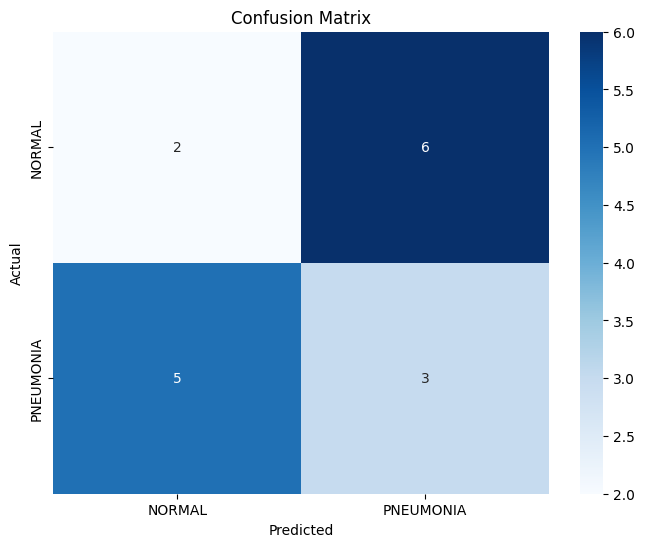

In [21]:
# ✅ STEP 12: Plot confusion matrix to visualize class-wise performance

cm = confusion_matrix(y_true, y_pred)
labels = list(val_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
